In [ ]:
from pipelines import unet_train
from pipeline_config import SOLUTION_CONFIG

pipe = unet_train(SOLUTION_CONFIG)
pipe

In [27]:
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.externals import joblib
masks = joblib.load('/mnt/ml-team/dsb_2018/kuba/trained_pipelines/unet_watershed_pipeline/outputs/thresholding')

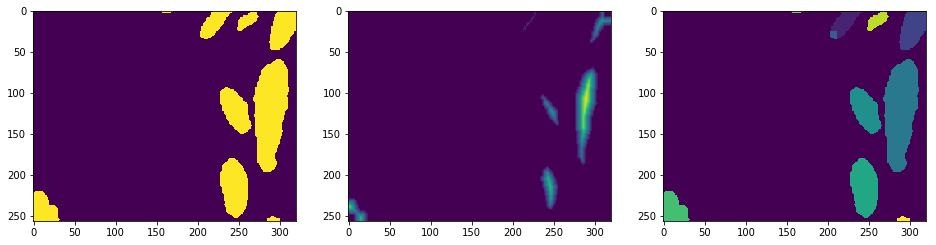

In [124]:
from scipy import ndimage as ndi
from sklearn.externals import joblib
from skimage.transform import resize
from skimage.morphology import watershed, erosion, square
from skimage.feature import peak_local_max

def detach_nuclei(image):
    distance = ndi.distance_transform_edt(image)

    eroded = distance
    for i in range(3):
        eroded = erosion(eroded, selem=square(5))

    markers,nr_blobs = ndi.label(eroded)
    labeled = watershed(-distance, markers, mask=image)
    
    dropped,_  = ndi.label(image - (labeled>0))
    dropped = np.where(dropped>0,dropped+nr_blobs,0)
    
    correct_labeled = dropped+labeled
    return correct_labeled, eroded

img = masks['binarized_images'][3]
img_w, eroded = detach_nuclei(img)

plt.figure(figsize=(16,10))
plt.subplot(131)
plt.imshow(img)
plt.subplot(132)
plt.imshow(eroded)
plt.subplot(133)
plt.imshow(img_w)
plt.show()